# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.672'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 2000
batch_size = 32

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
model.add(CuDNNLSTM(200))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mae", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 64)           16064     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               212800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 200)           321600    
_________________________________________________________________
dropout_2 (Dropout)  

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 2000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/2000
585/585 [==============================] - 2s 4ms/step - loss: 0.1256 - val_loss: 0.0822
Epoch 2/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0674 - val_loss: 0.0687
Epoch 3/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0531 - val_loss: 0.0628
Epoch 4/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0475 - val_loss: 0.0412
Epoch 5/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0443 - val_loss: 0.0594
Epoch 6/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0399 - val_loss: 0.0518
Epoch 7/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0372 - val_loss: 0.0319
Epoch 8/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0350 - val_loss: 0.0457
Epoch 9/2000
585/585 [=========

Epoch 77/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0197
Epoch 78/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0156 - val_loss: 0.0180
Epoch 79/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0158 - val_loss: 0.0187
Epoch 80/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0164 - val_loss: 0.0174
Epoch 81/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 82/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0184
Epoch 83/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0194 - val_loss: 0.0226
Epoch 84/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0174 - val_loss: 0.0179
Epoch 85/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0169 - val_loss: 0.0280
Epoch 86/2000
585/585 [==============================] - 1s 1ms/step - lo

Epoch 156/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0134 - val_loss: 0.0132
Epoch 157/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0140 - val_loss: 0.0140
Epoch 158/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0150 - val_loss: 0.0150
Epoch 159/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0151
Epoch 160/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 161/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0146 - val_loss: 0.0141
Epoch 162/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0147
Epoch 163/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0131 - val_loss: 0.0166
Epoch 164/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0141 - val_loss: 0.0130
Epoch 165/2000
585/585 [==============================] - 1s 1ms

Epoch 235/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0134 - val_loss: 0.0140
Epoch 236/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0131 - val_loss: 0.0142
Epoch 237/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0131 - val_loss: 0.0141
Epoch 238/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0137
Epoch 239/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0128 - val_loss: 0.0122
Epoch 240/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 241/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0120 - val_loss: 0.0133
Epoch 242/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0120 - val_loss: 0.0121
Epoch 243/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0123
Epoch 244/2000
585/585 [==============================] - 1s 1ms

Epoch 314/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0118
Epoch 315/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0116 - val_loss: 0.0119
Epoch 316/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 317/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0134
Epoch 318/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0137
Epoch 319/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0115 - val_loss: 0.0133
Epoch 320/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 321/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0132
Epoch 322/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 323/2000
585/585 [==============================] - 1s 1ms

Epoch 393/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0104 - val_loss: 0.0113
Epoch 394/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0131
Epoch 395/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 396/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0118
Epoch 397/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0142
Epoch 398/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 399/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0112 - val_loss: 0.0130
Epoch 400/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0108 - val_loss: 0.0113
Epoch 401/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0111 - val_loss: 0.0131
Epoch 402/2000
585/585 [==============================] - 1s 1ms

Epoch 472/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0123
Epoch 473/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0123
Epoch 474/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0113
Epoch 475/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0125
Epoch 476/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0137
Epoch 477/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 478/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 479/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0132
Epoch 480/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0104
Epoch 481/2000
585/585 [==============================] - 1s 1ms

Epoch 551/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0137
Epoch 552/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0154
Epoch 553/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0106
Epoch 554/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0120
Epoch 555/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0154
Epoch 556/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0114
Epoch 557/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0113
Epoch 558/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0132
Epoch 559/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0111
Epoch 560/2000
585/585 [==============================] - 1s 1ms

Epoch 630/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0118
Epoch 631/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0095 - val_loss: 0.0125
Epoch 632/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 633/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0091 - val_loss: 0.0097
Epoch 634/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0143
Epoch 635/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0131
Epoch 636/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0119
Epoch 637/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0149
Epoch 638/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 639/2000
585/585 [==============================] - 1s 1ms

Epoch 709/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0090 - val_loss: 0.0130
Epoch 710/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0129
Epoch 711/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0140
Epoch 712/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0123
Epoch 713/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0103
Epoch 714/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0091 - val_loss: 0.0113
Epoch 715/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0097
Epoch 716/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0132
Epoch 717/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 718/2000
585/585 [==============================] - 1s 1ms

Epoch 788/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0108
Epoch 789/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0088 - val_loss: 0.0096
Epoch 790/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0094 - val_loss: 0.0140
Epoch 791/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0127
Epoch 792/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0123
Epoch 793/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0129
Epoch 794/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0087 - val_loss: 0.0120
Epoch 795/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0110
Epoch 796/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0134
Epoch 797/2000
585/585 [==============================] - 1s 1ms

Epoch 867/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0118
Epoch 868/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0132
Epoch 869/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0126
Epoch 870/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0127
Epoch 871/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0083 - val_loss: 0.0133
Epoch 872/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0093 - val_loss: 0.0121
Epoch 873/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0086 - val_loss: 0.0101
Epoch 874/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0111
Epoch 875/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 876/2000
585/585 [==============================] - 1s 1ms

Epoch 946/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0084 - val_loss: 0.0126
Epoch 947/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0082 - val_loss: 0.0138
Epoch 948/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0137
Epoch 949/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0129
Epoch 950/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0082 - val_loss: 0.0118
Epoch 951/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 0.0134
Epoch 952/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0127
Epoch 953/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0127
Epoch 954/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0153
Epoch 955/2000
585/585 [==============================] - 1s 1ms

585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0110
Epoch 1025/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0121
Epoch 1026/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0134
Epoch 1027/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0113
Epoch 1028/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0081 - val_loss: 0.0120
Epoch 1029/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0124
Epoch 1030/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0126
Epoch 1031/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0077 - val_loss: 0.0124
Epoch 1032/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0137
Epoch 1033/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0131
Epoch 1103/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0134
Epoch 1104/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0117
Epoch 1105/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0078 - val_loss: 0.0159
Epoch 1106/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0131
Epoch 1107/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0142
Epoch 1108/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0119
Epoch 1109/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0142
Epoch 1110/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0129
Epoch 1111/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0076 - val_loss: 0.0125
Epoch 1181/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0080 - val_loss: 0.0134
Epoch 1182/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0120
Epoch 1183/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0116
Epoch 1184/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0138
Epoch 1185/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0117
Epoch 1186/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0129
Epoch 1187/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0141
Epoch 1188/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0083 - val_loss: 0.0146
Epoch 1189/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0134
Epoch 1259/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0132
Epoch 1260/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0116
Epoch 1261/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0134
Epoch 1262/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0120
Epoch 1263/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0115
Epoch 1264/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0079 - val_loss: 0.0151
Epoch 1265/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0114
Epoch 1266/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0137
Epoch 1267/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0132
Epoch 1337/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0134
Epoch 1338/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0122
Epoch 1339/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0123
Epoch 1340/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0144
Epoch 1341/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0105
Epoch 1342/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0146
Epoch 1343/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0136
Epoch 1344/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0135
Epoch 1345/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0146
Epoch 1415/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0129
Epoch 1416/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0123
Epoch 1417/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0156
Epoch 1418/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0138
Epoch 1419/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0074 - val_loss: 0.0122
Epoch 1420/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0138
Epoch 1421/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0137
Epoch 1422/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0069 - val_loss: 0.0147
Epoch 1423/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0137
Epoch 1493/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0139
Epoch 1494/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0132
Epoch 1495/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0142
Epoch 1496/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0170
Epoch 1497/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0073 - val_loss: 0.0135
Epoch 1498/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0145
Epoch 1499/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0138
Epoch 1500/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0068 - val_loss: 0.0147
Epoch 1501/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0110
Epoch 1571/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0120
Epoch 1572/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0133
Epoch 1573/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0122
Epoch 1574/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0136
Epoch 1575/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0126
Epoch 1576/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0135
Epoch 1577/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0132
Epoch 1578/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0133
Epoch 1579/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0139
Epoch 1649/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0162
Epoch 1650/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0157
Epoch 1651/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0147
Epoch 1652/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0132
Epoch 1653/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0154
Epoch 1654/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0141
Epoch 1655/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0138
Epoch 1656/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0147
Epoch 1657/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0131
Epoch 1727/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0160
Epoch 1728/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0122
Epoch 1729/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0119
Epoch 1730/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0123
Epoch 1731/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0134
Epoch 1732/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0124
Epoch 1733/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0131
Epoch 1734/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0144
Epoch 1735/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0132
Epoch 1805/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0140
Epoch 1806/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0136
Epoch 1807/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0143
Epoch 1808/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0122
Epoch 1809/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0126
Epoch 1810/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0065 - val_loss: 0.0134
Epoch 1811/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0146
Epoch 1812/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0163
Epoch 1813/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0122
Epoch 1883/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0064 - val_loss: 0.0152
Epoch 1884/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0128
Epoch 1885/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0139
Epoch 1886/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0149
Epoch 1887/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0141
Epoch 1888/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0144
Epoch 1889/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0144
Epoch 1890/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0144
Epoch 1891/2000
585/585 [==============================] - 1s 1ms/step 

585/585 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0165
Epoch 1961/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0143
Epoch 1962/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0153
Epoch 1963/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0142
Epoch 1964/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0162
Epoch 1965/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0137
Epoch 1966/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0142
Epoch 1967/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0142
Epoch 1968/2000
585/585 [==============================] - 1s 1ms/step - loss: 0.0058 - val_loss: 0.0129
Epoch 1969/2000
585/585 [==============================] - 1s 1ms/step 

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.000508885755468339
MSE Dev: 0.0010180206680781572
MSE Test: 0.0005340537557701091
MAE Train: 0.010293243930788735
MAE Dev: 0.015263394295088743
MAE Test: 0.012359482220271735


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

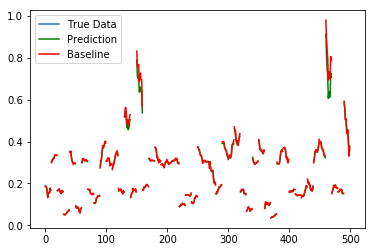

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

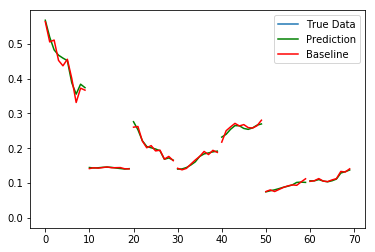

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 5.982552065251062e-05
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 5.982552065251062e-05


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

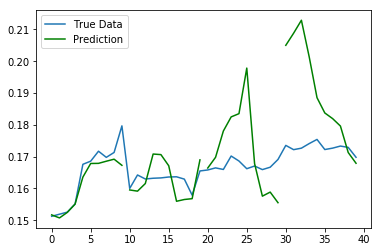

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

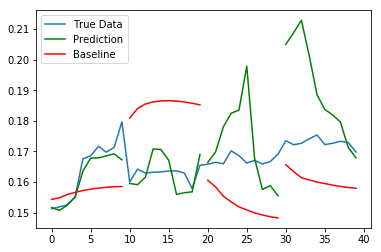

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.008873005194774242
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 0.00018593842662444453


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



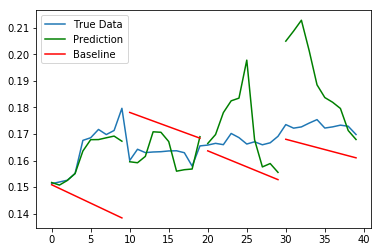

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.008873005194774242
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 0.00018593842662444453


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

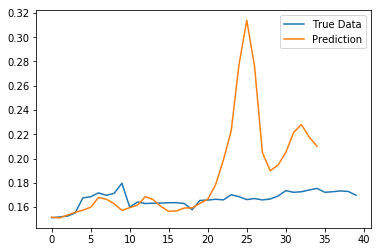

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)

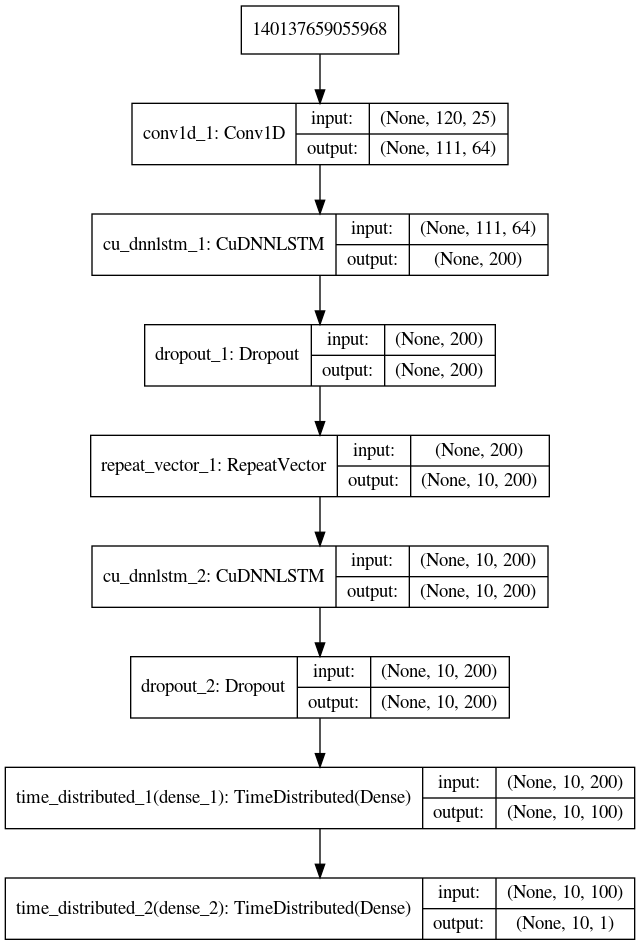

In [14]:
from IPython.display import SVG, Image, display
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_plot.png'))